# Temperature Forecasting Problem

## Loading

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import keras

Using TensorFlow backend.


In [3]:
data = pd.read_csv('jena_climate_2009_2016.csv')

In [9]:
data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [93]:
float_data = np.array(data)

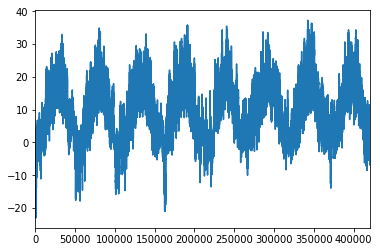

In [36]:
data['T (degC)'].plot()

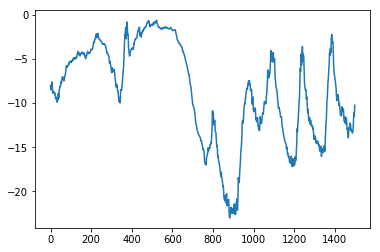

In [50]:
plt.plot(data['T (degC)'][:1500])

## Preprocessing

In [95]:
#Remove dates
float_data = np.array(data)
float_data = float_data[:,1:]

In [65]:
mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std

AttributeError: 'float' object has no attribute 'sqrt'

In [98]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
float_data_norm = normalizer.fit_transform(float_data)

In [99]:
def generator(data, lookback, delay, 
              min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) -delay -1
    i = max_index + lookback
    
    while 1:
        
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size= batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange((i,min(i+batch_size, max_index)))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback//step,
                           data.shape[-1]))
        
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [100]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Non-ML Baseline

In [102]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

TypeError: arange: scalar arguments expected instead of a tuple.